# Building A Handwritten Digits Classifier

Deep neural networks have been used to reach state-of-the-art performance on **image classification** tasks in the last decade. For some image classification tasks, deep neural networks actually perform as well as or slightly better than the human benchmark.

I am going to build models that can classify handwritten digits. Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

- First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.
- Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This often results in a loss of detail that's available for training and pattern matching.
- Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression.

In this Guided Project, I am going to explore the effectiveness of **deep**, **feedforward neural networks** at classifying images.

Scikit-learn contains a number of datasets pre-loaded with the library, within the namespace of sklearn.datasets. The load_digits() function returns a copy of the hand-written digits dataset from UCI.

Because data frames are a tabular representation of data, each image is represented as a row of pixel values. I am going to load this data, reshape and visualize some of them.

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

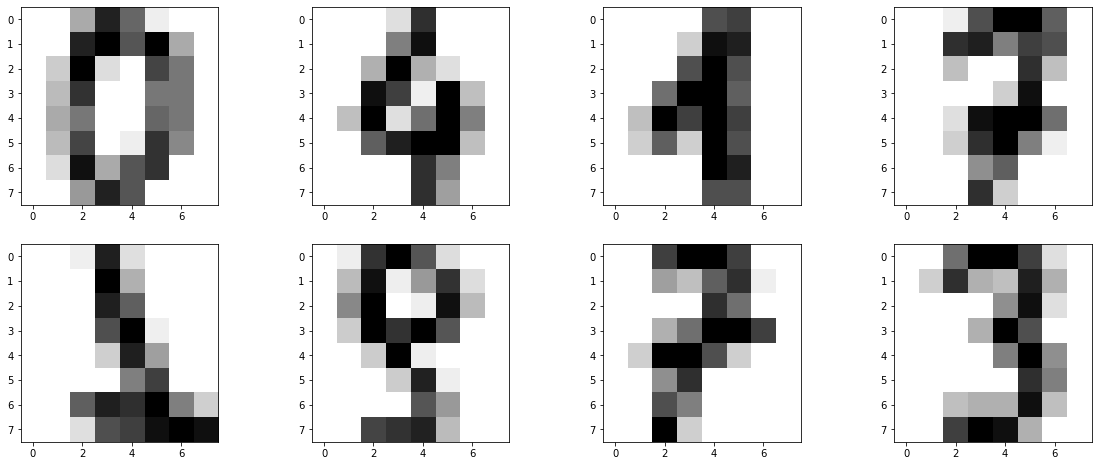

In [2]:
data, target = load_digits(return_X_y = True)
data = pd.DataFrame(data)
target = pd.Series(target)
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
plt_num = 0
for i in rows:
    image = data.iloc[i] 
    np_image = image.values
    np_image = np_image.reshape(8,8)
    plt_num += 1
    ax = plt.subplot(2,4,plt_num)
    ax.imshow(np_image, cmap='gray_r')

## k-nearest neighbors algorithm

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm makes no such assumption. This allows them to capture nonlinearity in the data.

I am going to use the KNeighborsClassifier package to train and test k-nearest neighbors models. Cross validation with k-fold as 4 is also applied.

In [5]:
def train(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_result = pd.DataFrame()
    train_result['true_result'] = test_target
    train_result['prediction'] = predictions
    accuracy = sum(train_result["prediction"] == train_result["true_result"])/len(train_result)    
    return accuracy

def cross_validate(k, df, target):
    kf = KFold(n_splits=4, random_state=2)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        knc = train(k, train_features, train_target)
        train_accuracy = test(knc, train_features, train_target)
        test_accuracy = test(knc, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = cross_validate(1, data, target)
mean_train_accuracies = np.mean(train_accuracies)
mean_test_accuracies = np.mean(test_accuracies)
print("mean_train_accuracies = ", mean_train_accuracies)
print("mean_test_accuracies = ", mean_test_accuracies)

mean_train_accuracies =  1.0
mean_test_accuracies =  0.9677233358079684


Let's have a look at the training and validation accuracy in one plot.

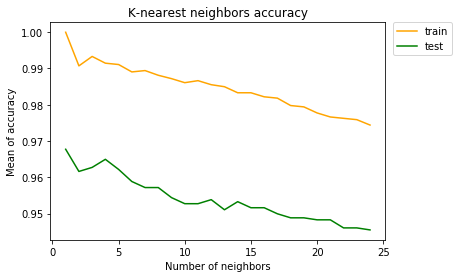

In [6]:
train_mean_accuracies = []
test_mean_accuracies = []
for k in range(1, 25):
    train_accuracies, test_accuracies = cross_validate(k, data, target)
    train_mean_accuracies.append(np.mean(train_accuracies))
    test_mean_accuracies.append(np.mean(test_accuracies))
x = range(1, 25)
y = train_mean_accuracies
plt.plot(x, y, color = 'orange', label = 'train')
y = test_mean_accuracies
plt.plot(x, y, color = 'green', label = 'test')

plt.xlabel('Number of neighbors')
plt.ylabel('Mean of accuracy')
plt.title('K-nearest neighbors accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

In [9]:
test_mean_accuracies

[0.9677233358079684,
 0.9616010888393962,
 0.9627183865379857,
 0.9649480326651819,
 0.9621665429349171,
 0.9588270230141054,
 0.9571591190299431,
 0.9571578817124474,
 0.9543801039346697,
 0.9527097253155159,
 0.9527047760455333,
 0.9538208364266271,
 0.9510343974263796,
 0.9532628062360802,
 0.9515924276169264,
 0.9515949022519178,
 0.9499232863152685,
 0.9488109378866617,
 0.948809700569166,
 0.9482566196486019,
 0.9482566196486018,
 0.9460294481563969,
 0.9460306854738926,
 0.9454738926008414]

The highest accuracy is when the number of neighbors is 1. It increased again at k = 4 especially in test data set. Increasing the number of neighbors reduces the accuracy with almost the same difference between the accuracy of the train and test data sets.

There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

Let's now try a **neural network** with a **single hidden layer** using the MLPClassifier package from scikit-learn.

## Neural Network with a single hidden layer

In [10]:
from sklearn.neural_network import MLPClassifier
def train_nn(neuron_arch, train_features, train_target):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch, random_state = 2)
    mlp.fit(train_features, train_target)
    return mlp
    
def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_result = pd.DataFrame()
    train_result['true_result'] = test_target
    train_result['prediction'] = predictions
    accuracy = sum(train_result["prediction"] == train_result["true_result"])/len(train_result)    
    return accuracy
 
def cross_validate(n_neurons, df, target):
    kf = KFold(n_splits=4, random_state=2)
    accuracies = []
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        model = train_nn(n_neurons, train_features, train_target)
        accuracy = test(model, test_features, test_target)
        accuracies.append(accuracy)    
    return accuracies

accuracies = cross_validate((8,), data, target)
np.mean(accuracies)

0.892600841375897

Let's try with different numbers of neurons.

Text(0.5, 1.0, 'Neural Network with single hidden layer')

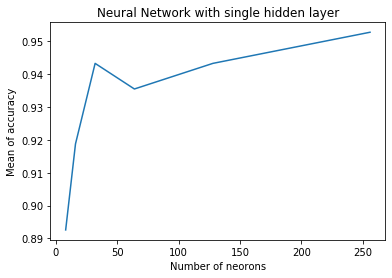

In [11]:
neurons = [(8,),
          (16,),
          (32,),
          (64,),
          (128,),
          (256,)]
mean_accuracies = []
for n in neurons:
    accuracies = cross_validate(n, data, target)
    mean_accuracies.append(np.mean(accuracies))
x = [i[0] for i in neurons]
y = mean_accuracies
plt.plot(x, y)
plt.xlabel('Number of neorons')
plt.ylabel('Mean of accuracy')
plt.title('Neural Network with single hidden layer')

By increasing the number of neurons in a single layer neural network, accuracy increase really well. Let's compare the accuracy of the train and test data set.

In [12]:
def cross_validate(n_neurons, df, target, nsplits = 4):
    kf = KFold(n_splits=nsplits, random_state=2)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        model = train_nn(n_neurons, train_features, train_target)
        train_accuracy = test(model, train_features, train_target)
        test_accuracy = test(model, test_features, test_target)
        train_accuracies.append(train_accuracy) 
        test_accuracies.append(test_accuracy) 
    return train_accuracies, test_accuracies
train_accuracies, test_accuracies = cross_validate((8,), data, target)
mean_train_accuracies = np.mean(train_accuracies)
mean_test_accuracies = np.mean(test_accuracies)
print("mean_train_accuracies = ", mean_train_accuracies)
print("mean_test_accuracies = ", mean_test_accuracies)

mean_train_accuracies =  0.9745870315174505
mean_test_accuracies =  0.892600841375897


In [13]:
def run_draw_nn(neurons, plt_title, nsplits = 4):
    train_mean_accuracies = []
    test_mean_accuracies = []
    for n in neurons:
        train_accuracies, test_accuracies = cross_validate(n, data, target, nsplits)
        train_mean_accuracies.append(np.mean(train_accuracies))
        test_mean_accuracies.append(np.mean(test_accuracies))
    x = [i[0] for i in neurons]
    y = train_mean_accuracies
    plt.plot(x, y, color = 'orange', label = 'train')
    y = test_mean_accuracies
    plt.plot(x, y, color = 'green', label = 'test')
    plt.xlabel('Number of neorons')
    plt.ylabel('Mean of accuracy')
    plt.title(plt_title)
    plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)
    return train_mean_accuracies, test_mean_accuracies

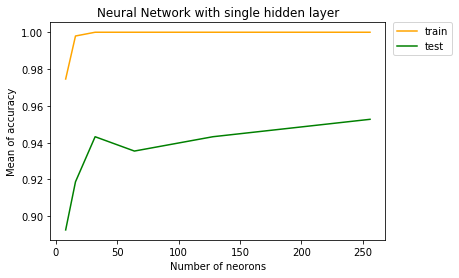

In [14]:
neurons = [(8,),
          (16,),
          (32,),
          (64,),
          (128,),
          (256,)]
train_mean_accuracies, test_mean_accuracies = run_draw_nn(neurons, 'Neural Network with single hidden layer')

In [17]:
test_mean_accuracies

[0.892600841375897,
 0.9187391734719129,
 0.9432293986636971,
 0.9354441969809453,
 0.9432343479336798,
 0.9526948775055679]

In the Neural Network single layer the accuracy of the model with lots of neurons (256) is about 95% which is less than 97% the accuracy that we have got from the k-neighbor classification algorithm. Neural Networks with a single layer gets very soon to 100% accuracy for the train data set but acts poorly for the test data set which is the sign of overfitting.

Let's try using two hidden layers and continue to increase the number of neurons in each layer.

## Neural Network with two hidden layers

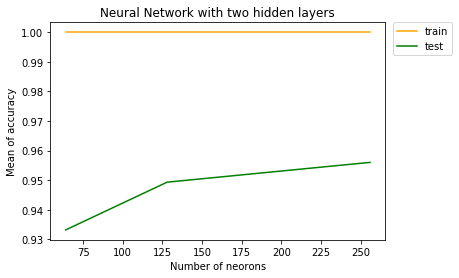

In [18]:
neurons = [(64,64),
          (128,128),
          (256,256)]
train_mean_accuracies, test_mean_accuracies = run_draw_nn(neurons, 'Neural Network with two hidden layers')

In [20]:
test_mean_accuracies

[0.9332182628062361, 0.9493504083147736, 0.9560368720613709]

The accuracy of the test data set has improved to 96%. Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

## Neural Network with three hidden layers

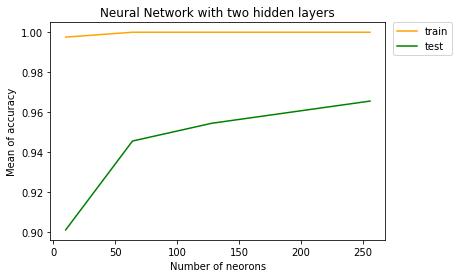

In [22]:
neurons = [(10,10,10),
          (64,64,64),
          (128,128,128), 
          (256, 256, 256)]
train_mean_accuracies, test_mean_accuracies = run_draw_nn(neurons, 'Neural Network with two hidden layers', 6)

In [25]:
test_mean_accuracies

[0.9009364548494984, 0.945473801560758, 0.9543738387216649, 0.9654998141954664]

It seems Neural Networks with three hidden layers and using 6 fold cross validation improves the test set accuracy to 97%.

## Visualization of MLP Weights on MNIST

Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. For example, if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high.
Let's look at the visualized weights. I use this [resource](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html) to implement it.

[(64, 256), (256, 256), (256, 10)]
First layer:


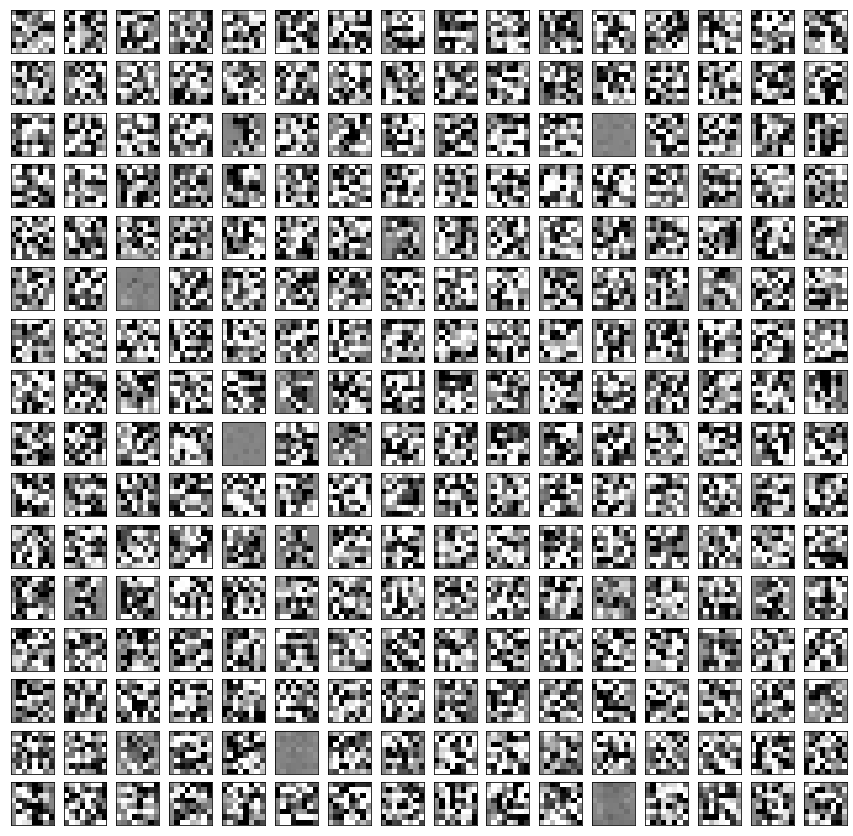

Second layer:


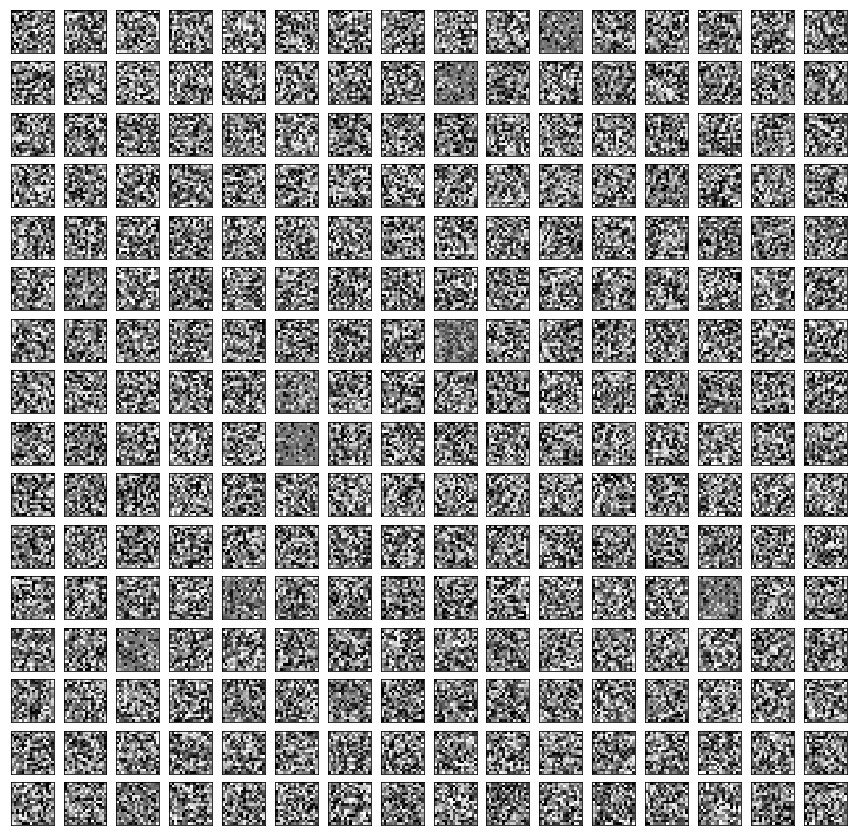

Output layer:


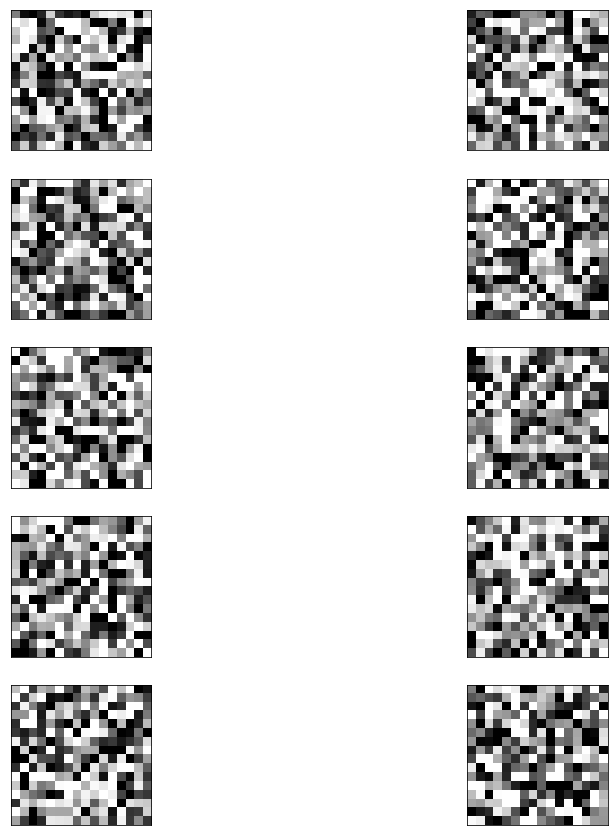

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.9566666666666667,
  0.9833333333333333,
  0.9566666666666667,
  0.9665551839464883,
  0.9899665551839465,
  0.9331103678929766])

In [157]:
def visualize_nn_weights(coef, X_train, y_train, X_test, y_test, layer = 0):
    row = 16
    col = 16
    if layer ==2:
        row = 5
        col = 2
    fig, axes = plt.subplots(row, col, figsize=(15,15))
    # use global min / max to ensure all weights are shown on the same scale
    vmin, vmax = coef[layer].min(), coef[layer].max()
    for coef, ax in zip(coef[layer].T, axes.ravel()):
        if layer == 0:
            ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
        else:
            ax.matshow(coef.reshape(16,16), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
        
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

def cross_validate(n_neurons, df, target, nsplits = 4, layer = 0):
    kf = KFold(n_splits=nsplits, random_state=2)
    train_accuracies = []
    test_accuracies = []
    coefs = []
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]
        model = train_nn(n_neurons, train_features, train_target)        
        coefs.append(model.coefs_)
        train_accuracy = test(model, train_features, train_target)
        test_accuracy = test(model, test_features, test_target)
        train_accuracies.append(train_accuracy) 
        test_accuracies.append(test_accuracy) 
    
    print([coef.shape for coef in model.coefs_])
    print("First layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 0)
    print("Second layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 1)
    print("Output layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 2)
    return train_accuracies, test_accuracies
cross_validate((256, 256), data, target, 6, 1)

## Summay

In this project, I practiced solving classifying handwritten digits using the k-nearest neighbors algorithm and neural networks with different numbers of neurons and different hidden layers. The best result has been achieved using the MLP classifier Neural Network with three hidden layers.

**Next steps:**
- Use the existing pipeline to try other machine learning models:
    - Decision Tree Models
    - Random Forest Models
- Experiment with different activation functions to see if the accuracies improve.